# Learning the committor
Reference papers: 
- _Kang, Trizio and Parrinello, [Nat Comput Sci](https://doi.org/10.1038/s43588-024-00645-0) (2024), [ArXiv](https://arxiv.org/abs/2401.05279)_
- _Trizio, Kang and Parrinello, [Nat Comput Sci](https://doi.org/10.1038/s43588-025-00799-5) (2025), [ArXiv](https://arxiv.org/abs/2410.17029)_

For a more practical example, see also the more advanced tutorial on training the committor for alanine dipeptide in the examples notebooks.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/cvs_committor.ipynb)


## Introduction

Given an a system presenting two metastable states $A$ and $B$, the commmittor $q(\mathbf{x})$ is a function that for each configuration $\mathbf{x}$gives the probability that it will evolve to $B$ before having passed through $A$.

#### Learning the committor
One way to learn the committor function is to leverage the variational principle introduced by Kolmogorov, which amounts to satisfying the boundary conditions
$$ q(\mathbf{x}_A) = 0 \quad \text{and} \quad  q(\mathbf{x}_B) = 1$$
to minimizing the functional $K[q(\mathbf{x})]$ of the committor
$$ K[q(\mathbf{x})] \quad=\quad \frac{1}{Z} \int | \nabla_u q(\mathbf{x})|^2 e^{-\beta U (\mathbf{x})} d \mathbf{x} \quad=\quad  \langle | \nabla_u q(\mathbf{x})|^2  \rangle_{U (\mathbf{x})}$$
where $\nabla_u$ denotes the gradient wrt the mass-scaled Cartesian coordinates, $Z$ is the partition function function associated to the potential $U(\mathbf(x))$ and the last term represent the ensemble average over the corresponding Boltzmann ensemble.

To do it practically, we parametrize the committor as a Neural Network (NN) $q_\theta(\mathbf{x})$ and we minimize the variational principle for its optimization.
More in detail, we use some physical descriptors $\mathbf{d}(\mathbf{x})$ as input of the NN, obtain an output $z(\mathbf{x})=NN(\mathbf{d}(\mathbf{x}))$ to which we apply a sigmoid-like activation function $\sigma$ to help impose the right functional form to the final committor function $q(\mathbf{x})=\sigma(z(\mathbf{x}))$.

#### Kolmogorov bias potential
As most of the contribution to $K[q(\mathbf{x})]$ comes from the TS region which is hard to sample in conventional MD runs, we introduced the TS-oriented **Kolmogorov bias potential** 
$$ V_K = -\frac{\lambda}{\beta} \log(|\nabla q(\mathbf{x})|^2) $$
which allows extensively sampling the TS region, thus enabling the use of the variational principle. 

#### Effective committor-based CV
Even if the committor provides an *ideal* reaction coordinate as it allows describing the reactive process from state A to state B, it is not a suitable *collective variable* for enhanced sampling.
This is because all the configurations from the metastable basins are degenerate along the committor, if not for very tiny numerical differences, thus making it impossible to use it with enhanced sampling algorithms such as OPES or Metadynamics.

A solution to this issue is not to use directly the committor $q$ as a CV, but the *non-activated* $z$ function, which encodes the same information but is suitable for an enhanced sampling setup.

<center><img src="images/committor_cv.png" width="800" /></center>

#### Extensive sampling along the committor-based CV
As we have a good CV to be used, we can combine the $V_K$ bias, which stabilizes the TS region and promotes its sampling, with a CV-based algorithm like OPES, which fills the basins and promote transitions with them. This way we can cover the whole phase space sampling extensively both the transition and metastable states.

<center><img src="images/OPES_VK.png" width="800" /></center>





 

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Initialize committor model and training variables

In [ ]:
from mlcolvar.cvs.committor import Committor,initialize_committor_masses

# temperature
T = 1 
# Boltzmann factor in the RIGHT ENREGY UNITS!
kb = 1
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

atomic_masses = initialize_committor_masses(atom_types=[0], masses=[1])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

model = Committor(layers=[2, 32, 32, 1],
                    atomic_masses=atomic_masses,
                    alpha=1e-1,
                    delta_f=0,
                    n_dim=2,
                    options=options)

Beta: 1.0 
1/beta: 1.0


## Load data
**NOTE** Here, as we only showcase the workings of the code, we directly use data collected at the end of the iterative process for convenience.
In general, however, one is supposed to collect a progressively better dataset through some iterations of the method, an example is availbale in the [more advanced tutorial on Alanine Dipeptide](https://github.com/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_committor.ipynb) in the examples section of the tutorials.

In [3]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

################################### SET THINGS HERE ###################################
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/unbiased_sims/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/unbiased_sims/B/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_0/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_0/B/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/B/COLVAR'
            ]

load_args = [{'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
            ]           

# #######################################################################################

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels=True,
                                               filter_args={'regex': 'p.x|p.y'}, # to load many positions --> 'regex': 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'
                                               return_dataframe=True,
                                               load_args=load_args,
                                               verbose=True)
# fill empty entries from unbiased simulations
dataframe = dataframe.fillna({'opes.bias': 0})
dataframe = dataframe.fillna({'bias': 0})
bias = torch.Tensor(dataframe['opes.bias'].values + dataframe['bias'].values)

dataset = compute_committor_weights(dataset, bias, [0, 1, 2, 3, 4, 5], beta)

# create datamodule with only training set
datamodule = DictModule(dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 13)
Class 1 dataframe shape:  (2000, 13)
Class 2 dataframe shape:  (9000, 24)
Class 3 dataframe shape:  (9000, 24)
Class 4 dataframe shape:  (9000, 24)
Class 5 dataframe shape:  (9000, 24)

 - Loaded dataframe (40000, 27): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels', 'mueller', 'potential.bias', 'potential.mueller_bias', 'z.node-0', 'z.bias-0', 'q', 'bias', '@8.bias', '@8.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker']
 - Descriptors (40000, 2): ['p.x', 'p.y']


### Visualize training set

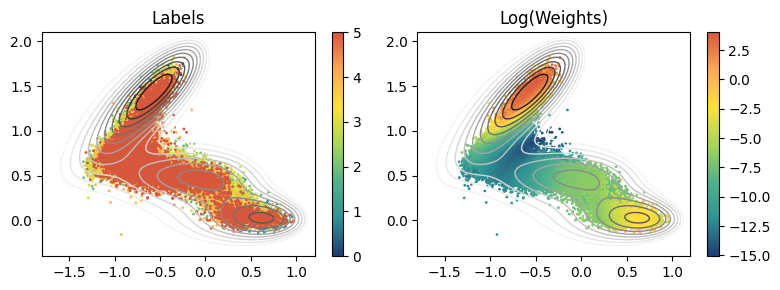

In [4]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')

plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=dataset['labels'], s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=torch.log(dataset['weights']), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

## Initialize trainer and fit model

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 1.2 K  | [1, 2]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | [1, 1]   | [1, 1]   
------------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 19999: 100%|██████████| 1/1 [00:00<00:00, 31.92it/s]

`Trainer.fit` stopped: `max_epochs=20000` reached.


Epoch 19999: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s]


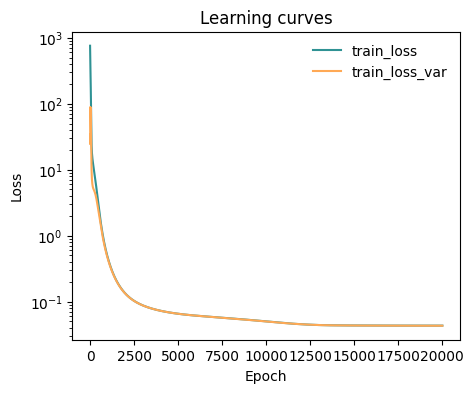

In [5]:
from mlcolvar.utils.trainer import MetricsCallback
from lightning.pytorch.callbacks import ModelCheckpoint

# define callbacks
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", save_top_k=10, monitor="train_loss_epoch", every_n_epochs=50)

# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000 at least
trainer = lightning.Trainer(callbacks=[metrics, checkpoint_callback], max_epochs=5, logger=False, enable_checkpointing=True,
            limit_val_batches=0, num_sanity_val_steps=0, accelerator='cpu'
        )

# fit model
trainer.fit(model, datamodule)

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log')

## Visualize results

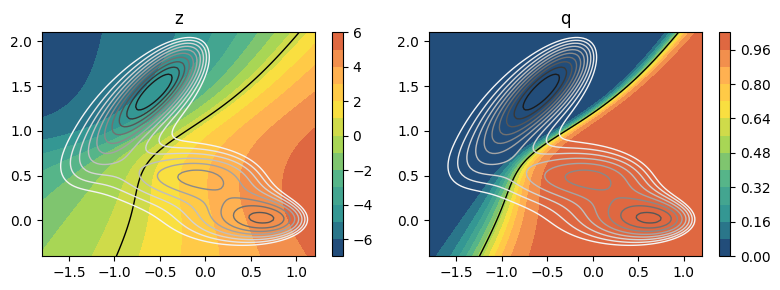

In [6]:
# save sigmoid activation of output layer to go from z to q
import copy
Sigmoid = copy.copy(model.sigmoid)

fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot z --> sigmoid activation off
ax = axs[0]
ax.set_title('z')
model.sigmoid = None
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)

# plot q --> sigmoid activation on
ax = axs[1]
ax.set_title('q')
model.sigmoid = Sigmoid
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()

## Visualize Kolmogorov bias 

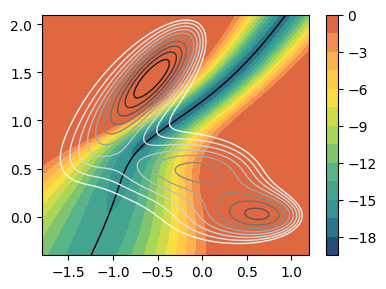

In [7]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

model_bias = KolmogorovBias(input_model=model, beta=beta, epsilon=1e-6, lambd=1)

fig, ax = plt.subplots(1,1,figsize=(4,3))
plot_isolines_2D(model_bias, ax=ax, colorbar=True, allow_grad=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()

## Export model with tracing

In [8]:
traced_model = model.to_torchscript(file_path='test_trace.pt', method='trace')